# Data analysis on smartphones on __[Jumia](https://jumia.co.ke)__

### Objective:
1. **Descriptive Statistics:**
   - Compute basic statistical measures for product prices, ratings, display and battery capacity.

2. **Price Analysis:**
   - Explore the distribution of product prices.
   - Analyze the correlation between attributes.

3. **Feature Correlation:**
   - Investigate relationships between different product features.

4. **Customer Sentiment Analysis:**
   - Perform sentiment analysis on product reviews to gauge customer sentiment.
   - Explore whether there's a correlation between positive reviews and high ratings.

5. **Visualization:**
   - Create visualizations to understand the distribution and relationships among product attributes.

By addressing these objectives, the analysis aims to provide insights into the characteristics, features, and customer sentiment associated with the products on Jumia. These findings can inform decision-making processes and strategic planning for product offerings and marketing strategies.

### Necessary library imports

In [1]:
import requests, re, os
from bs4 import BeautifulSoup as bs4
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from collections import Counter

## Data mining

#### Define page to scrape

In [2]:
url = "https://www.jumia.co.ke/smartphones/"

#### Extract products from HTML soup

In [3]:
def get_products(soup):
    return soup.find_all('article', class_='prd _fb col c-prd')

#### Extract the brands

In [4]:
def get_brands(soup):
    items = []
    brands = soup.find(class_="-phs -pvxs -df -d-co -h-168 -oya -sc").find_all(class_="fk-cb -me-start -fsh0")
    for brand in brands:
        items.append(brand.text)
    return items

#### Extract the product rating

In [5]:
def get_rating(product):
    rating = product.find('div', class_='stars _s')
    if not rating is None: 
        return rating.text.replace(' out of 5', '')
    else:
        return 0

#### Extract a product's number of reviews

In [6]:
def reviews_count(product):
    rev_class = product.find('div', class_='rev')
    data = ''
    if not rev_class is None:
        pattern = r'\((.*?)\)' # Find text in parenthesis eg (321)
        reviews = re.findall(pattern, rev_class.text)[0]
        for match in reviews:
            data += match
        return data
    else:
        return 0

#### Extract product RAM, ROM

In [7]:
def get_memory(input_string):
    gb_pattern = re.compile(r'(\d+)\s*GB', re.IGNORECASE)
    gb_matches = gb_pattern.findall(input_string)

    if not gb_matches:
        return None, None

    gb_values = [int(match) for match in gb_matches]
    ram = min(gb_values)
    rom = max(gb_values)

    return ram, rom

#### Extract product battery capacity

In [8]:
def get_battery(input_string):
    mah_pattern = re.compile(r'(\d{1,3}(?:,\d{3})*|\d+(?:\.\d+)?)\s*MAH', re.IGNORECASE)

    mah_match = mah_pattern.search(input_string)

    if mah_match:
        capacity_str = mah_match.group(1).replace(',', '')
        capacity = int(capacity_str)
        return capacity
    else:
        return 0

#### Extract product screen size

In [9]:
def get_display(input_string):
    # Regex pattern to find display size following several variations
    display_size_pattern = re.compile(
        r'(\d+(\.\d+)?)\s*(?:\'\'|"|\")?(?:[^\w.]|\b)(?:inch(?:es)?|HD|size|screen|display|")',
        re.IGNORECASE
    )
    display_size_match = display_size_pattern.search(input_string)

    if display_size_match:
        display_size_str = display_size_match.group(1)
        display_size = float(display_size_str)
        return display_size
    else:
        return 0

#### Extract product info

In [10]:
def get_info(product):
    brand = product.find('a', class_='core', attrs={"data-brand": True})['data-brand']

    # Extract price, remove 'KSh' and commas, convert to numeric
    price = product.find('div', class_='info').find('div', class_='prc').text.replace('KSh ','').replace(',','')

    description = product.find('h3', class_='name').text.lower()
    name = description.split(',')[0]

    # Extract product attributes
    ram, rom = get_memory(description)
    rating = get_rating(product)
    reviews = reviews_count(product)
    battery = get_battery(description)
    display = get_display(description)
    has_express = "Express Shipping" in str(product)

    link = url + product.find('a', class_='core', href=True)['href']
    product_id = product.find('a', class_='core', attrs={"data-id": True})['data-id']

    # Return dictionary with extracted information
    return {
        'id': product_id,
        'name': name,
        'description': description,
        'brand': brand,
        'price': price,
        'display': display,
        'ram': ram,
        'rom': rom,
        'battery': battery,
        'rating': float(rating),
        'reviews': reviews,
        'express': has_express,
        'link': link
}

#### Fetch a product's reviews

In [11]:
def fetch_reviews(product_id):
    reviews_page = f"https://www.jumia.co.ke/catalog/productratingsreviews/sku/{product_id}"
    soup = bs4(requests.get(reviews_page).content)
    pages = soup.find('a', {'aria-label': 'Last Page'})

    reviews = [] # List to store the extracted reviews
    
    # Extract and iterate through reviews pages if multiple pages exist
    if not pages is None:
        pages = int(pages.get('href').split('page=')[-1])
        for page in range(1, pages+1):
            rev_url = f"{reviews_page}/?page={page}"
            
            rsoup = bs4(requests.get(rev_url).content)

            articles = rsoup.find_all('article', class_='-pvs')
            
            # Append each review text to the reviews list
            for article in articles:
                review = article.find('p', class_="-pvs")
                reviews.append(review.text)
    
    return reviews

#### Extract products from page

In [12]:
def fetch_data(to_page=None):
    soup = bs4(requests.get(url).text, 'html.parser')
    total_pages = soup.find('a', {'aria-label': 'Last Page'})
    
    if not total_pages is None:
        pages = re.search(r'(\d+)', total_pages.get('href').split('page=')[-1]).group(0)
    
    data = [] # List to store the scraped data
    
    # If a specific page is specified, set the total pages to that value
    if not to_page is None:
        pages = to_page
    
    # Iterate through each page to fetch data
    for page in range(int(pages) + 1):
        catalog = f"{url}/?page={page}"
        catalog_soup = bs4(requests.get(catalog).content, 'html.parser')
        
        products = get_products(catalog_soup)
        
        # Iterate through each product and append its information to the data list
        for product in products:
            info = get_info(product)
            if info['brand'] != 'Generic':
                data.append(info)
    return data

#### Fetch products data

In [13]:
# Fetch data from first (n) number of pages, none for all
data = fetch_data() 

#### Data cleaning and preprocessing

In [14]:
# Create a DataFrame
dataFrame = pd.DataFrame(data)

# Drop empty rows (rows with NaN values)
df = dataFrame.dropna()
df = dataFrame[['id', 'name', 'brand', 'price', 'display', 'ram', 'rom', 'battery', 'rating', 'reviews', 'express']]

# Data type conversion for numeric columns
df.loc[:, 'reviews'] = df['reviews'].astype(int)
df.loc[:, 'battery'] = df['battery'].astype(int)
df.loc[:, 'rom'] = pd.to_numeric(df['rom'], errors='coerce').astype('Int32')
df.loc[:, 'ram'] = pd.to_numeric(df['ram'], errors='coerce').astype('Int32')
df.loc[:, 'display'] = pd.to_numeric(df['display'], errors='coerce').astype('float')

# Exclude rows where values are 0
df = df[df['battery'] != 0]
df = df[df['ram'] != 0]
df = df[df['rom'] != 0]

# Exclude products with invalid display sizes
df = df[(df['display'] != 0) & (df['display'] < 10.0)]
# Exclude rows where RAM and ROM are the same
df = df[df['rom'] != df['ram']]

#### Save data to csv

In [15]:
# Filter rows where 'price' is an integer or a valid numeric value
df = df[df['price'].apply(lambda x: isinstance(x, int) or 
                          (isinstance(x, (float, str)) and x.replace('.', '', 1).isdigit()))]

# Convert the 'price' to integer
df['price'] = df['price'].astype(int)

# Save data to CSV
df.to_csv('smartphones.csv', index=False)

## Analysis and visualization

#### Overview of DataFrame

In [47]:
# Non-smartphone brands to exclude
exclude = [
    'HP', 'Fashion', 'Energizer', 'Kemey', 
    'Oraimo', 'Budi', 'T&G', 'Advance',
    'Kkmoon', 'Jiebo', 'Jbl', 'Boost', 'Renewed'
]
# Select rows where the 'brand' column is NOT in the list of smartphone brands.
df = df[~df['brand'].isin(exclude)]
# Display first 5 products in the DataFrame
df.head(5)

,id,name,brand,price,display,ram,rom,battery,rating,reviews,express
0,XI996MP23ZV7SNAFAMZ,xiaomi redmi a2+,XIAOMI,11599,6.52,3,64,5000,4.0,33,True
1,IN213MP359DDYNAFAMZ,infinix smart 7 hd,Infinix,11999,7.00,2,64,5000,4.4,174,True
2,OP896MP0IKHW7NAFAMZ,oppo a17k,Oppo,13589,6.56,3,64,5000,4.5,37,True
3,TE685MP1YBG1ONAFAMZ,tecno pop 7,Tecno,12150,6.60,2,64,5000,4.4,71,True
4,OP896MP01TOFFNAFAMZ,oppo a17k,Oppo,13999,6.56,3,64,5000,4.2,45,True


In [17]:
df.shape

(1035, 11)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1035 entries, 0 to 1953
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1035 non-null   object 
 1   name     1035 non-null   object 
 2   brand    1035 non-null   object 
 3   price    1035 non-null   int32  
 4   display  1035 non-null   float64
 5   ram      1035 non-null   Int32  
 6   rom      1035 non-null   Int32  
 7   battery  1035 non-null   int64  
 8   rating   1035 non-null   float64
 9   reviews  1035 non-null   object 
 10  express  1035 non-null   bool   
dtypes: Int32(2), bool(1), float64(2), int32(1), int64(1), object(4)
memory usage: 79.8+ KB


In [19]:
df.describe()

,price,display,ram,rom,battery,rating
count,1035.000000,1035.000000,1035.0,1035.0,1035.000000,1035.000000
mean,20109.414493,6.564686,4.920773,112.0,4958.326570,1.884155
std,12865.121296,0.311288,2.886892,72.467855,683.974402,2.180856
min,5880.000000,5.000000,1.0,8.0,2400.000000,0.000000
25%,13297.000000,6.520000,3.0,64.0,5000.000000,0.000000
50%,17500.000000,6.600000,4.0,128.0,5000.000000,0.000000
75%,23299.000000,6.670000,8.0,128.0,5000.000000,4.300000
max,204999.000000,8.700000,16.0,256.0,10200.000000,5.000000


#### Getting insights on the data

In [20]:
# Calculate the correlation matrix
df[['price', 'display', 'ram', 'rom', 'battery']].corr()

,price,display,ram,rom,battery
price,1.000000,0.185309,0.499067,0.650287,0.135248
display,0.185309,1.000000,0.306750,0.262053,0.675594
ram,0.499067,0.306750,1.000000,0.775074,0.281365
rom,0.650287,0.262053,0.775074,1.000000,0.206598
battery,0.135248,0.675594,0.281365,0.206598,1.000000


Based on the information from the correlation matrix we can conclude that:
- There is a moderate positive correlation between the price and the amount of RAM (0.499) and ROM (0.65), indicating that devices with more memory tend to be pricier.
- There is a strong positive correlation between display size and battery capacity (0.67). This indicates that, on average, devices with larger displays tend to have bigger battery capacities.
- There is a strong positive correlation between RAM and ROM. This suggests that, on average, devices with more RAM also tend to have more storage capacity.

#### Brand Distribution within a Specific Price Range

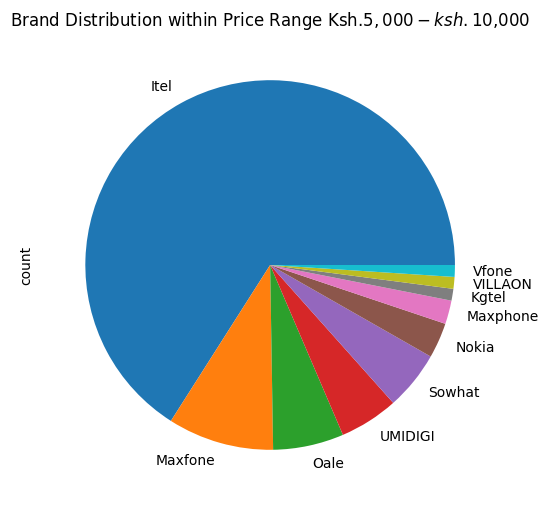

In [21]:
price_range_min = 5000  #minimum
price_range_max = 10000  #maximum

# Filter the DataFrame for the specified price range
filtered_df = df[(df['price'] >= price_range_min) & (df['price'] <= price_range_max)]

# Plot a pie chart of brand distribution within the price range
filtered_df['brand'].value_counts().plot(kind='pie', figsize=(6, 6))
plt.title(f'Brand Distribution within Price Range Ksh.${price_range_min:,} - ksh.${price_range_max:,}')
plt.show()

From the pie chart, we can conclude that **Itel** has the most products under the price range of KES.5,000 to KES 10,000

#### Top 10 cheapest and highest rated by brand

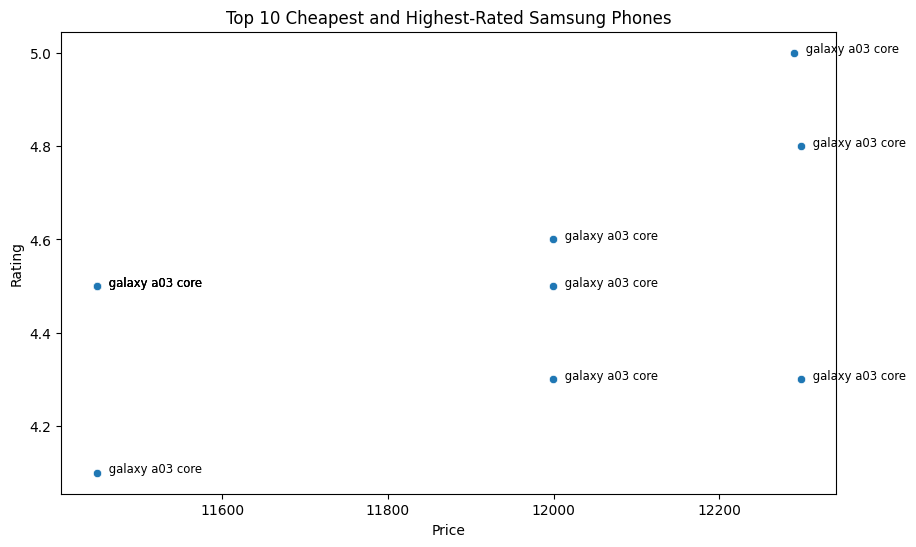

In [22]:
# Brand to visualize
brand_to_plot = 'Samsung'

# Filter the data for the specified brand
filtered_data = df[df['brand'] == brand_to_plot]
# Filter only phones rated 4 stars and above
filtered_data = filtered_data[filtered_data['rating'] >= 4]

# Sort the data by price and rating in descending order
sorted_data = filtered_data.sort_values(by=['price', 'rating'], ascending=[True, False])

# Select the top 10 cheapest and highest-rated phones
top_10_data = sorted_data.head(10)

# Create a scatter plot of price vs. rating for the selected phones
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='price', y='rating', data=top_10_data)

# Annotate points with model names
for line in range(0, top_10_data.shape[0]):
    phone_name = top_10_data['name'].iloc[line]
    model_name = phone_name.split(brand_to_plot, 1)[-1].strip()
    scatter_plot.text(
        top_10_data['price'].iloc[line] + 10,
        top_10_data['rating'].iloc[line],
        model_name.replace(brand_to_plot.lower(), ''),
        horizontalalignment='left',
        size='small',
        color='black'
    )

plt.xlabel('Price')
plt.ylabel('Rating')
plt.title(f'Top 10 Cheapest and Highest-Rated {brand_to_plot} Phones')
plt.show()

We can see that Samsung's **Galaxy A03 Core** is the cheapest Samsung smartphone on Jumia with the highest rating across different vendors.

#### Top 10 most purchased products

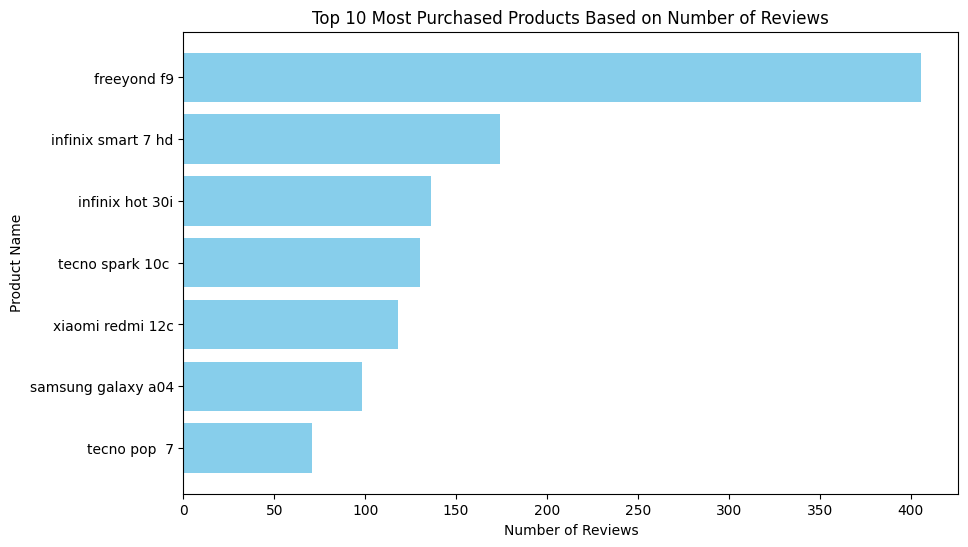

In [23]:
# Sort the data by the number of reviews in descending order
sorted_data = df.sort_values(by='reviews', ascending=False)

# Select the top 10 most purchased products
top_10_products = sorted_data.head(20)

# Create a bar chart to visualize the top 10 most purchased products
plt.figure(figsize=(10, 6))
plt.barh(top_10_products['name'], top_10_products['reviews'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.ylabel('Product Name')
plt.title('Top 10 Most Purchased Products Based on Number of Reviews')
plt.gca().invert_yaxis()  # Invert the y-axis for better readability
plt.show()

From the chart above, **Freeyond F9** tops as the most purchased product followed by the **Infinix Smart 7**.

### Analysis on the most purchased product

Now, let's focus specifically on the product "Freeyond F9" and analyze it even further to get more insights.

In [24]:
most_purchased_product = df.loc[df['reviews'].idxmax()]
most_purchased_product

id         FR407MP1MTBS3NAFAMZ
name               freeyond f9
brand                 Freeyond
price                    11590
display                   6.52
ram                          2
rom                         64
battery                   5000
rating                     4.0
reviews                    406
express                   True
Name: 460, dtype: object

Rating at 4.0 with 406 reviews, let's examine how these reviews relate to the provided ratings.

In [25]:
most_purchased_product = df.loc[df['reviews'].idxmax()]
reviews = fetch_reviews(most_purchased_product.id)

#### Prepare text for NLP

In [26]:
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = text.translate(str.maketrans("", "", string.punctuation)) # Remove punctuation
    tokens = word_tokenize(text) # Tokenization
    stop_words = set(stopwords.words('english')) # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer() # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

#### Analyze sentiment

In [27]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns a value between -1 and 1

In [28]:
reviews[:10] #First 10 reviews

['So far, so good , no complain  ???? still enjoying it ',
 'My favorite phn',
 'The best phone',
 'The phone is awesome',
 'Reliable',
 'Nice one',
 'Very smart and long life battery, I am to one very soonest ',
 'It takes long to charge ',
 'It experienced software problem. I can feel funny sounds when not in use.',
 'Long lasting battery ']

#### Sentiment summary of reviews

In [30]:
total_reviews = len(reviews)
positive_reviews = sum(1 for review in reviews if analyze_sentiment(review) > 0)
negative_reviews = sum(1 for review in reviews if analyze_sentiment(review) < 0)
neutral_reviews = total_reviews - positive_reviews - negative_reviews

# Calculate percentages
positive_percentage = (positive_reviews / total_reviews) * 100
negative_percentage = (negative_reviews / total_reviews) * 100
neutral_percentage = (neutral_reviews / total_reviews) * 100

rating_percentage = most_purchased_product['rating']/5 * 100
print(f"Rating {most_purchased_product['rating']} - {rating_percentage:.0f}%")
print("\nSummary of the reviews:")
print(f"{positive_percentage:.0f}% are positive")
print(f"{negative_percentage:.0f}% ae negative")
print(f"{neutral_percentage:.0f}% are neutral")

Rating 4.0 - 80%

Summary of the reviews:
62% are positive
9% ae negative
29% are neutral


**Conclusion:** The phone reviews generally reflect a positive sentiment, with an average rating of 4.0 aligning closely with the sentiment analysis results. Approximately 62% of users expressed satisfaction, which is consistent with the high rating. A minority of 9% had neutral opinions, and a mere 29% conveyed negative sentiments. Overall, the majority of users seem content with their purchase, supporting the positive nature of both the numerical rating and sentiment analysis results

### Average ratings by brand

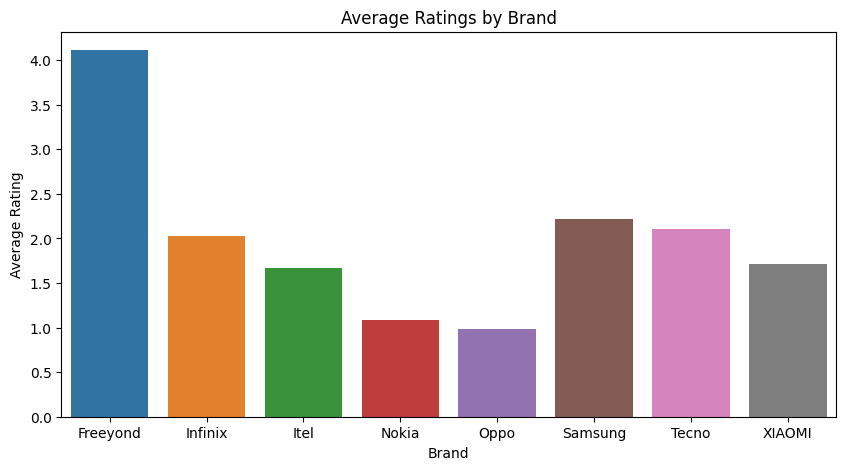

In [31]:
# Brands to visualize
brands_to_plot = ['Samsung', 'Nokia', 'Infinix', 'Tecno', 'Oppo', 'Itel', 'XIAOMI', 'Freeyond']
# Filter the data for the specified brands
filtered = df[df['brand'].isin(brands_to_plot)]
# Calculate the average ratings for each brand
avg_ratings_by_brand = filtered.groupby('brand')['rating'].mean().reset_index()
# Create a bar plot of average ratings by brand
plt.figure(figsize=(10, 5))
sns.barplot(x='brand', y='rating', data=avg_ratings_by_brand, hue='brand')

plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.title('Average Ratings by Brand')
plt.show()

The bar plot highlights that **Freeyond** leads with an average rating of approximately 4.0, surpassing other brands whose ratings tend to fall below average, with Oppo registering the lowest rating.

### Price vs. Rating

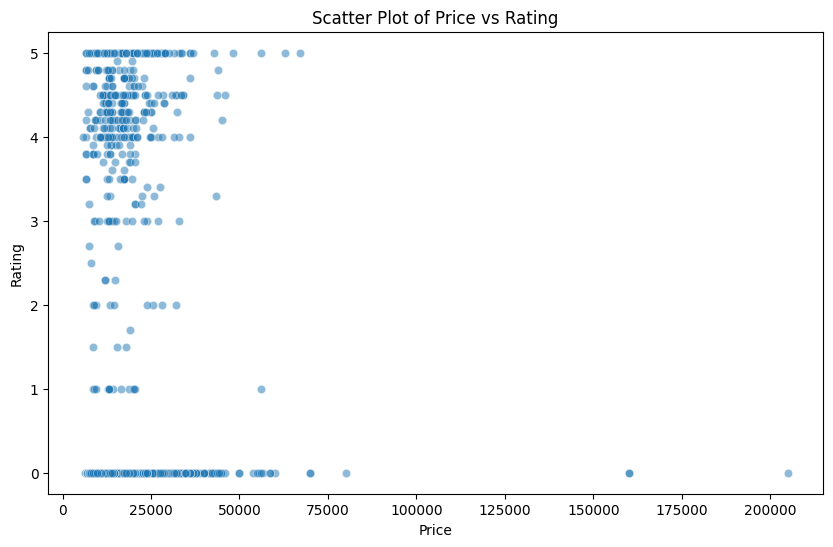

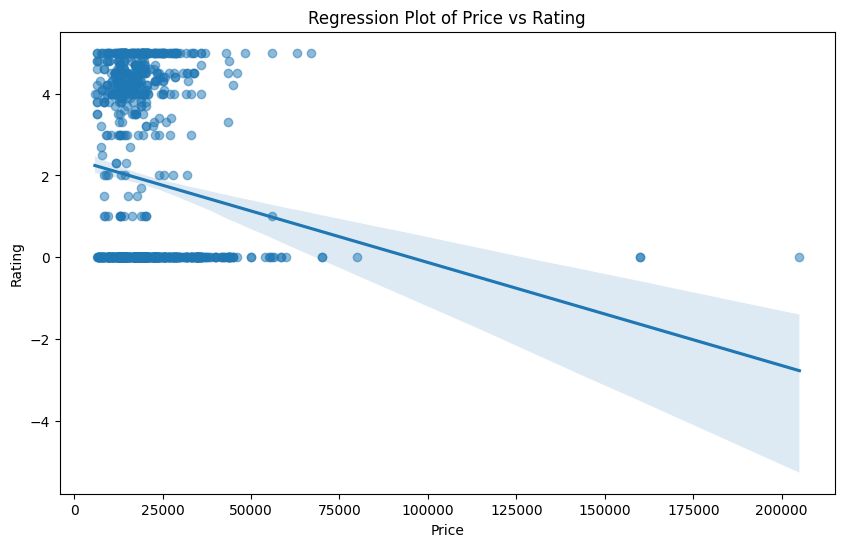

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['price'], y=df['rating'], data=df, alpha=0.5)
plt.title('Scatter Plot of Price vs Rating')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

plt.figure(figsize=(10, 6))
sns.regplot(x=df['price'], y=df['rating'], data=df, scatter_kws={'alpha':0.5})
plt.title('Regression Plot of Price vs Rating')
plt.xlabel('Price')
plt.ylabel('Rating')
plt.show()

The regression plot illustrates a negative correlation between product price and rating, indicating that products with a higher price margin tend to receive lower ratings. This finding suggests a discernible trend: as the price increases, the associated product rating tends to decrease.

### Price vs. Rating for Specific Brands with Price Ranges

<Figure size 800x600 with 0 Axes>

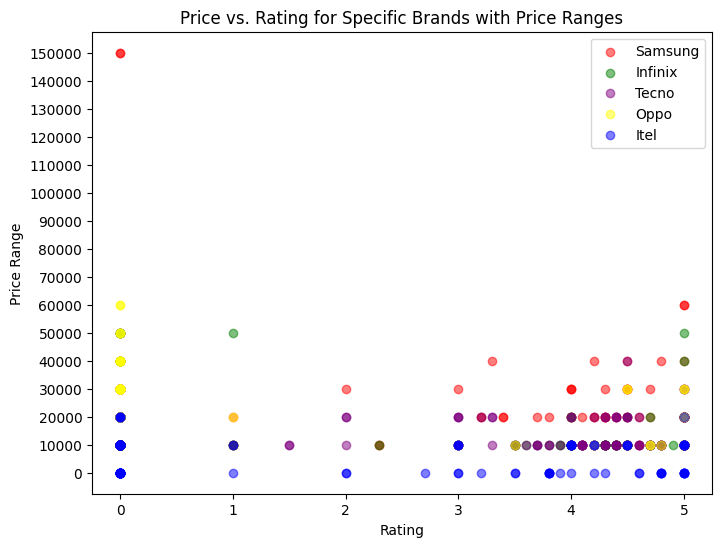

In [33]:
#Scatter Plot of Price vs. Rating
plt.figure(figsize=(8, 6))
brands_to_plot = ['Samsung', 'Infinix', 'Tecno', 'Oppo', 'Itel']
filtered = df[df['brand'].isin(brands_to_plot)]
#define price ranges
price_ranges = np.arange(0, filtered['price'].max() + 10000, 10000)
# Create a new DataFrame with the price ranges
filtered_with_ranges = filtered.copy()
filtered_with_ranges.loc[:, 'price_range'] = pd.cut(filtered_with_ranges['price'], bins=price_ranges, labels=price_ranges[:-1])

# Create a color map for brands
brand_colors = {
    'Samsung': 'red',
    'Infinix': 'green',
    'Tecno': 'purple',
    'Oppo': 'yellow',
    'Itel': 'blue',
}

plt.figure(figsize=(8, 6))

# Plot each brand separately and add a legend
for brand, color in brand_colors.items():
    brand_data = filtered_with_ranges[filtered_with_ranges['brand'] == brand]
    plt.scatter(brand_data['rating'], brand_data['price_range'], label=brand, c=color, alpha=0.5)

plt.xlabel('Rating')
plt.ylabel('Price Range')
plt.title('Price vs. Rating for Specific Brands with Price Ranges')
plt.yticks(price_ranges[:-1], [str(r) for r in price_ranges[:-1]])
plt.legend()
plt.show()



**Insights:**

1. **Itel's Market Position:**
   - Itel dominates the lower price margin, boasting the highest number of products in this segment.
   - Notably, the ratings for Itel's products are distributed unevenly, indicating a diverse range of customer opinions.

2. **Oppo's Rating Dynamics:**
   - Oppo's products are predominantly situated in the lower-rated spectrum.
   - This suggests a trend where, on average, Oppo products receive lower ratings compared to other brands in the analysis.

3. **Samsung's Premium Appeal:**
   - Samsung products prominently feature in the higher end of the ratings spectrum.
   - This observation aligns with a perception of Samsung as a brand that tends to deliver products garnering favorable reviews, possibly signaling a focus on quality and customer satisfaction.

### Number of products by brand

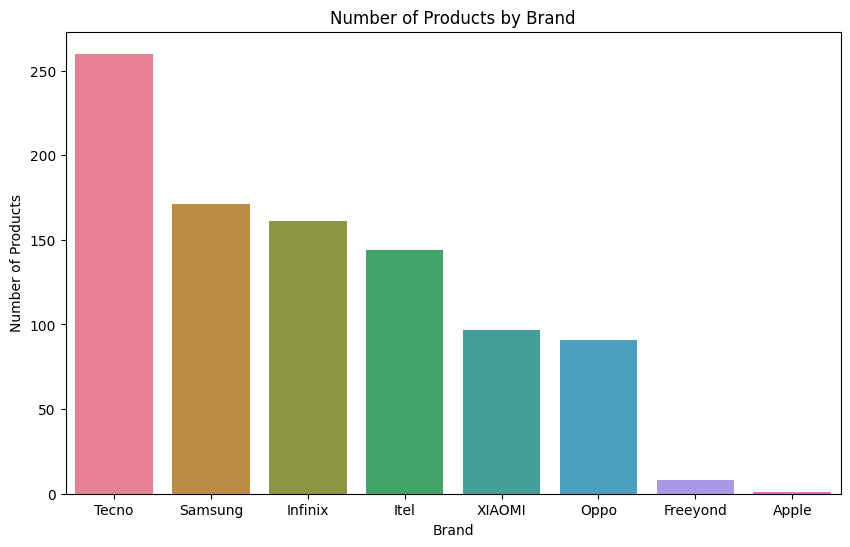

In [34]:
brands_to_plot = ['Samsung', 'Infinix', 'Tecno', 'Oppo', 'Itel', 'Apple', 'Freeyond', 'XIAOMI', 'Huawei', 'Blackberry']
filtered = df[df['brand'].isin(brands_to_plot)]

brand_counts = filtered['brand'].value_counts()

# Create a bar plot to visualize the number of products by brand
plt.figure(figsize=(10, 6))
sns.barplot(x=brand_counts.index, y=brand_counts.values, palette='husl', hue=brand_counts.index, dodge=False)

plt.xlabel('Brand')
plt.ylabel('Number of Products')
plt.title('Number of Products by Brand')
plt.show()

In the chart, **Tecno** stands out as the brand boasting the most extensive product range, showcasing a diverse and expansive portfolio. In contrast, **Apple** and **Freeyond** present a more focused selection, underscoring a strategic and curated approach to their product offerings. Notably, **Freeyond** devices were particularly highly rated in the context of this analysis.

### Most purchased products comparison

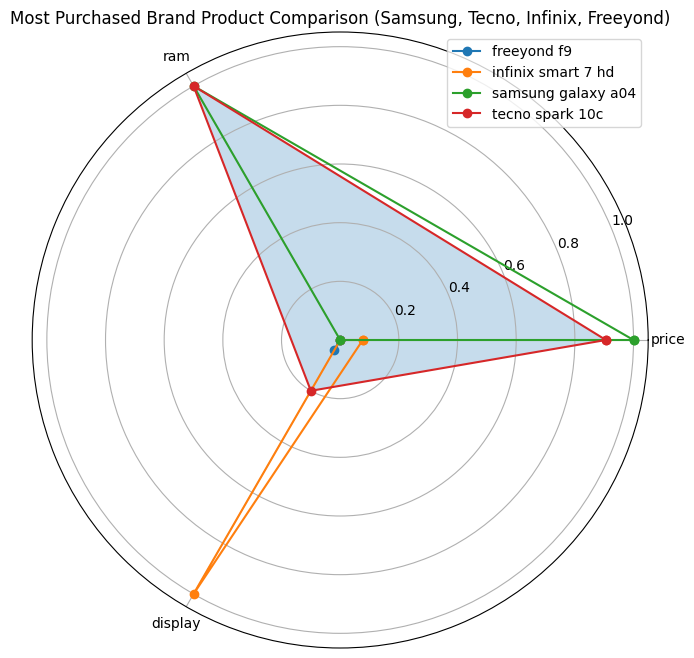

In [36]:
# Define the attributes for the radar chart
attributes = ['price', 'ram', 'display']

# Find the most reviewed product for each brand
most_reviewed_products = df.loc[df.groupby('brand')['reviews'].idxmax()]

# Filter the data to include only specified brands
selected_brands = ['Samsung', 'Tecno', 'Infinix', 'Freeyond']
filtered_data = most_reviewed_products[most_reviewed_products['brand'].isin(selected_brands)].copy()

# Normalize the data for each attribute to fit within the same scale (0-1)
for attribute in attributes:
    filtered_data[attribute] = (filtered_data[attribute] - filtered_data[attribute].min()) / (filtered_data[attribute].max() - filtered_data[attribute].min())

# Create a radar chart
num_attributes = len(attributes)
angles = np.linspace(0, 2 * np.pi, num_attributes, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 8))
for index, row in filtered_data.iterrows():
    values = row[attributes].values.tolist()
    values += values[:1]
    plt.polar(angles, values, marker='o', label=row['name'])

title = f'Most Purchased Brand Product Comparison ({", ".join(selected_brands)})'
plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], attributes)
plt.legend(loc='upper right')
plt.title(title)
plt.show()

In the radar chart analysis, several key observations stand out:

- **Infinix Smart 7** boasts the largest display size coupled with the lowest price point.
- **Samsung Galaxy A04** emerges as the most expensive among the highly purchased products on Jumia.
- **Tecno Spark 10C** takes the lead with the highest RAM configuration.
- Interestingly, **Freeyond** exhibits minimal visibility on the radar chart, indicating unique characteristics or potential outliers within the dataset.

#### Distribution of features

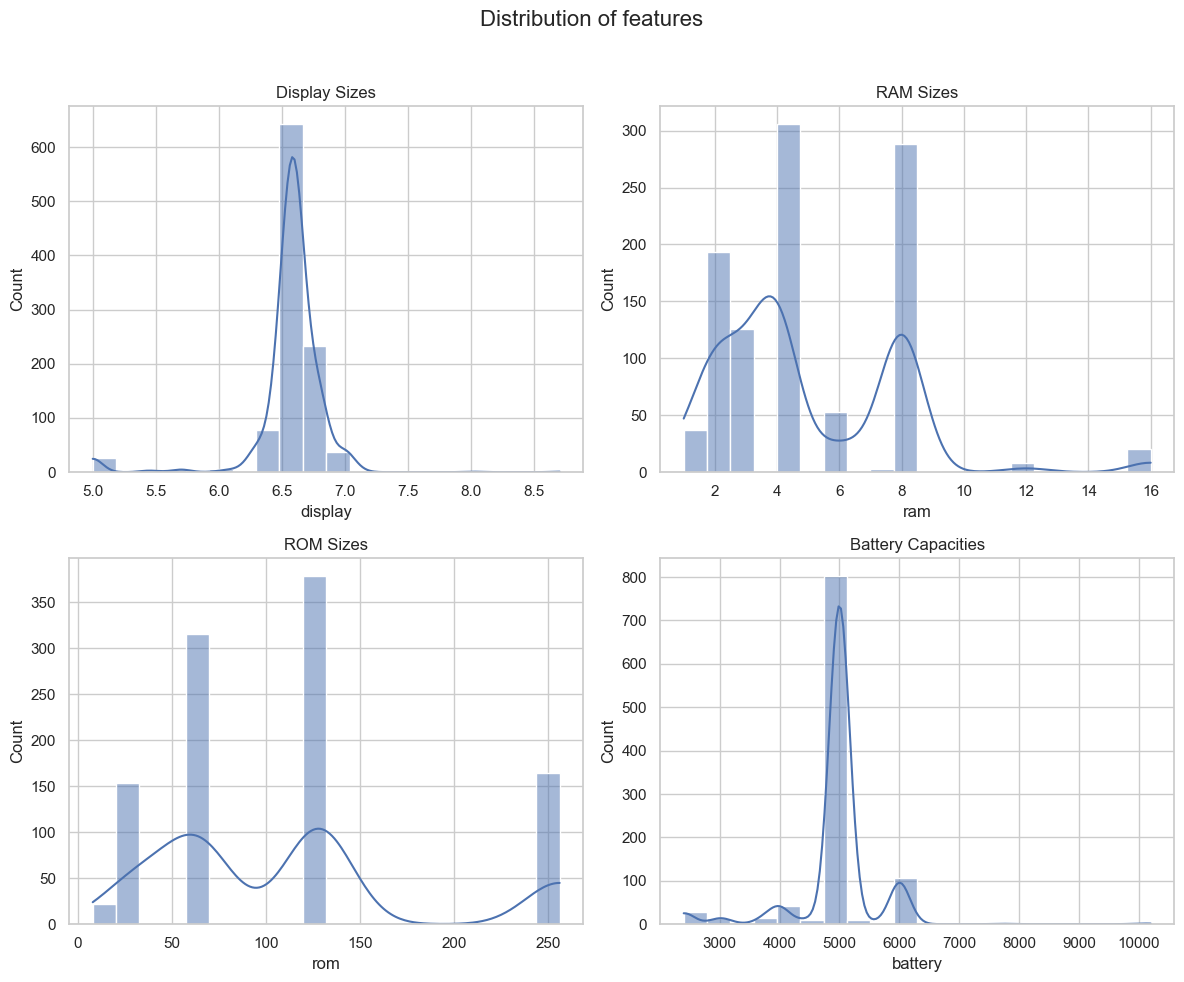

In [39]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Distribution of features", fontsize=16)

# Histogram for Display Sizes
sns.histplot(df['display'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Display Sizes")

# Histogram for RAM Sizes
sns.histplot(df['ram'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("RAM Sizes")

# Histogram for ROM Sizes
sns.histplot(df['rom'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("ROM Sizes")

# Histogram for Battery Capacities
sns.histplot(df['battery'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Battery Capacities")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()
